<a href="https://colab.research.google.com/github/hannesstuehrenberg/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/08-1SHXXXX_football_analytics/projects/08-1SHXXXX_football_analytics/report/08-1SHXXXX_football_analytics_Probabilistic_Machine_Learning_Project_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probabilistic Machine Learning - Project Report - Football Analytics

**Course:** Probabilistic Machine Learning (SoSe 2025)  
**Lecturer:** Alvaro Dias-Ruelas  
**Student(s) Name(s):** Hannes Stührenberg  
**GitHub Username(s):** hannesstuehrenberg  
**Date:** 15.08.2025  
**PROJECT-ID:** 08-1SHXXXX



## 1. Introduction


In recent years, football analytics has become an increasingly data-driven field, with advanced metrics such as expected goals (xG) now a regular feature in match broadcasts, scouting reports or tactical analysis reaching beyond the usual possession or shot count statistics. This project investigates whether football shot outcomes can be more effectively modeled by explicitly incorporating uncertainty into xG predictions.

Hudl Statsbomb claims to be offering the most comprehensive and flexible football data. The company makes some of their data freely available to equip the next generation of analysts with the tools, training and resources needed to succeed in the industry. The available data range from historical matches to analyse [legends of the game](https://www.hudl.com/blog/statsbomb-icons-pele) over [outstanding seasons](https://blogarchive.statsbomb.com/news/free-statsbomb-data-bayer-leverkusens-invincible-bundesliga-title-win/) and [tournaments](https://blogarchive.statsbomb.com/news/statsbomb-release-free-2023-womens-world-cup-data/) to [all league matches from Lionel Messis career](https://www.hudl.com/blog/statsbomb-release-free-lionel-messi-data-psg-and-inter-miami). In total there are data on every event that happend in over 3000 matches from more than 20 competitions. They are puplished on the [statsbomb github](https://github.com/statsbomb/open-data). [Libraries for processing the data](https://mplsoccer.readthedocs.io/en/latest/) in python are also available.

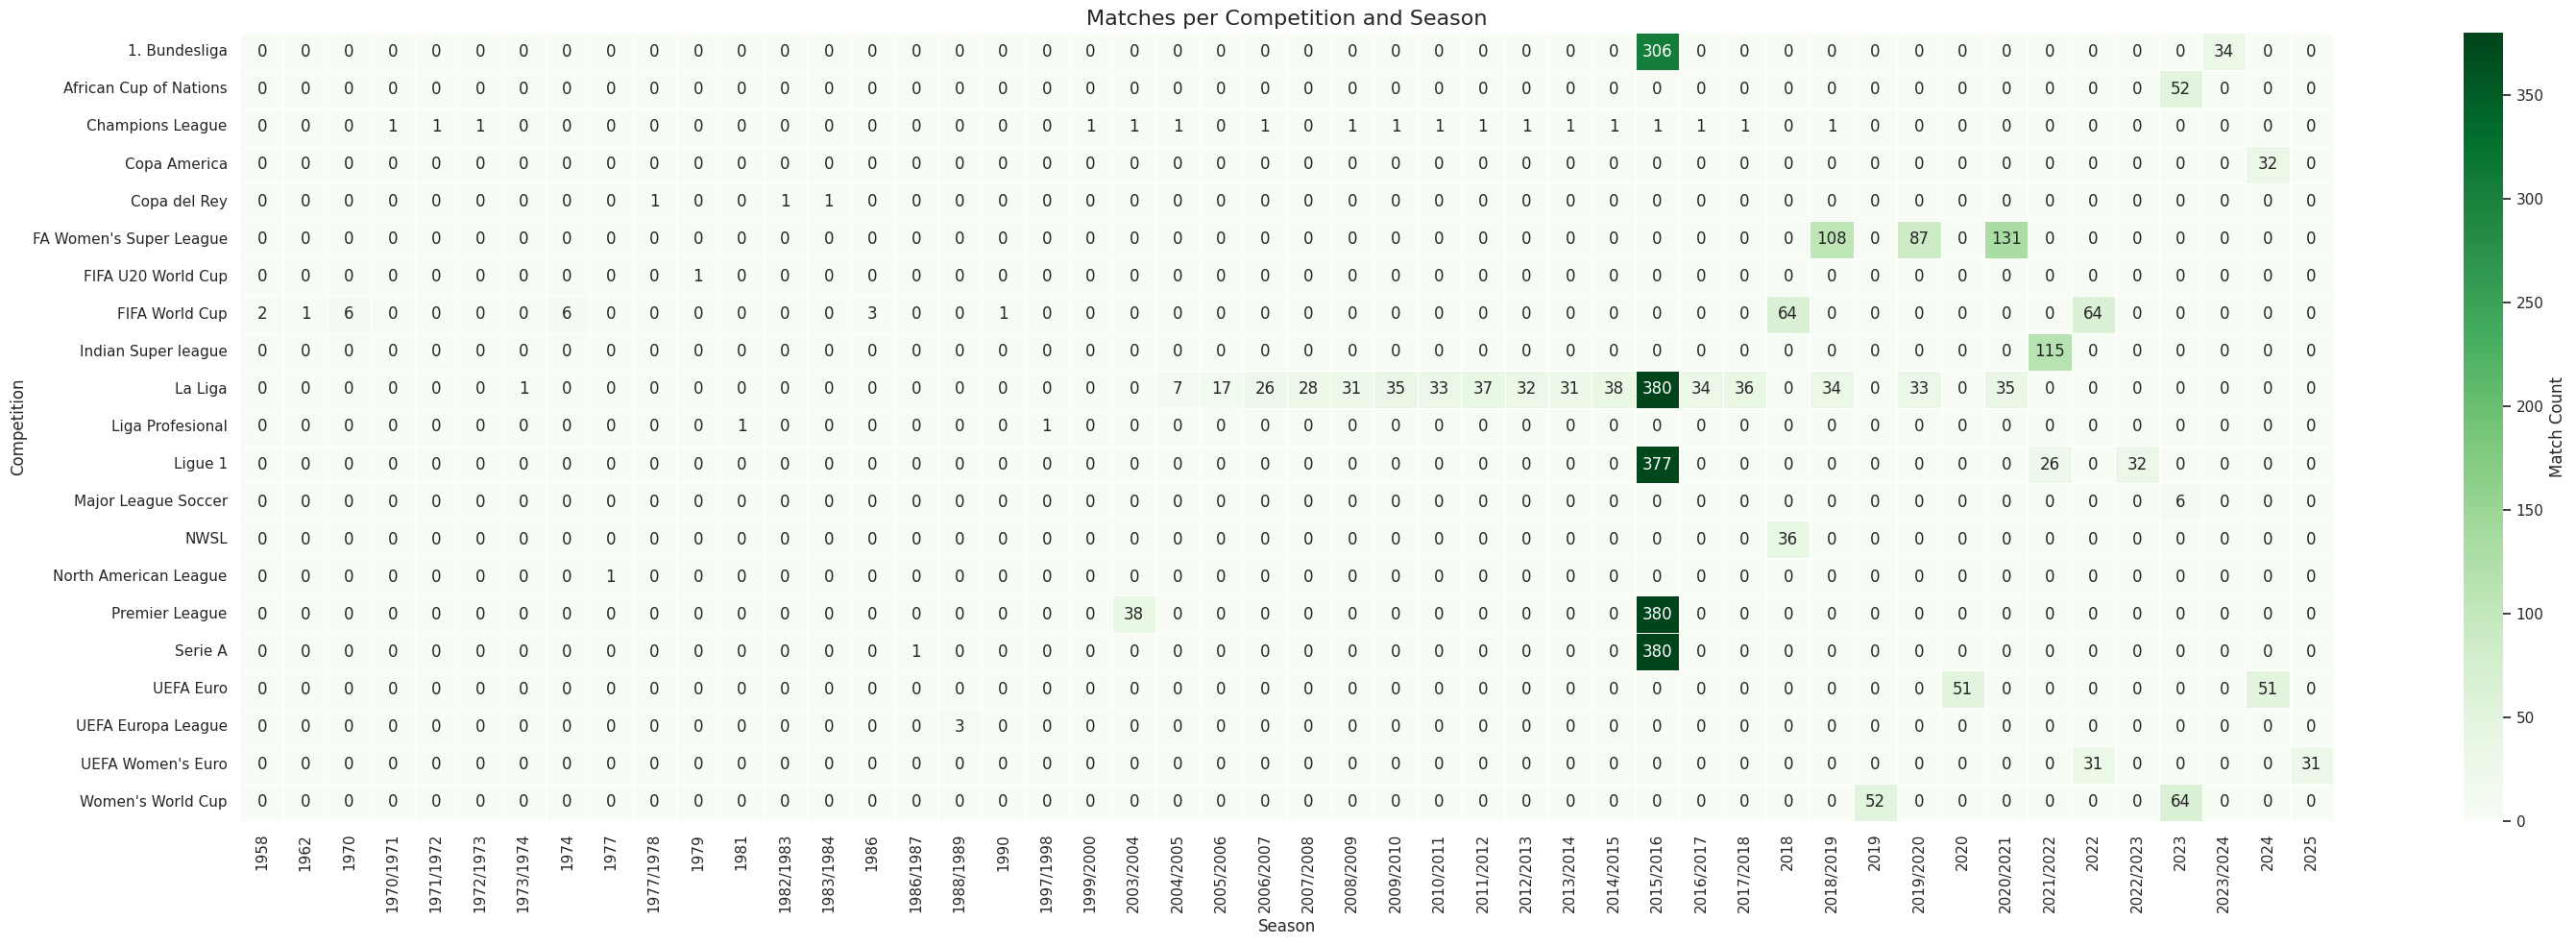

The project aims to address the following questions:

* How does explicitly modeling predictive uncertainty influence the accuracy and interpretability of xG estimates?
* Can uncertainty quantification reveal differences between players or shot types that point estimates overlook?
* How do probabilistic models compare to standard approaches in supporting practical football applications such as scouting, tactical design, and player development?

To answer these questions, the project compares probabilistic and non-probabilistic methods, evaluating their performance and the additional insights gained from uncertainty measures. The analysis explores how this richer information can distinguish players who consistently create high-quality chances from those with more volatile performance, ultimately enabling better-informed recruitment, lineup, and tactical decisions.

 Using the StatsBomb event data, all recorded shots are processed to construct feature representations that capture spatial, contextual, and tactical aspects of chance creation. These features are then used to train both traditional point-estimate models, such as logistic regression, and probabilistic approaches, including Bayesian logistic regression and Bayesian neural networks.


## 2. Data Loading and Exploration


The data used in the project originate from the publicly available StatsBomb Open Data repository, which is hosted on GitHub at [https://github.com/statsbomb/open-data](https://github.com/statsbomb/open-data). As stated in the introduction, StatsBomb provides detailed event-level data for over 3000 matches from more than 20 competitions. For every match, the event interface returns four primary dataframes. The first, `df_event`, contains the event log, including actions such as passes, shots and tackles. The second, `df_related`, links events to other, contextually associated actions. For instance, a shot may be related to a goalkeeper save or a block, with these connections captured through event identifiers. The third, `df_freeze`, provides freeze-frame data for each shot, recording the positions of all relevant players and the ball at the precise moment the shot is taken. Finally, `df_tactics` documents the tactical setups and line-ups for both teams at the start of the match. Together, these dataframes provide both the chronological sequence of match events and the contextual information needed for more advanced analyses. **(Quelle einfügen)**

For the project, the primary focus is on shot events extracted from the event data supplemented with their corresponding freeze-frame snapshots. The backbone `df_event` therby includes a wide range of columns describing every recorded action in a match. Figure X shows the frequncy of event types for Leipzigs match against Leverkusen from the 2023/2024 season.

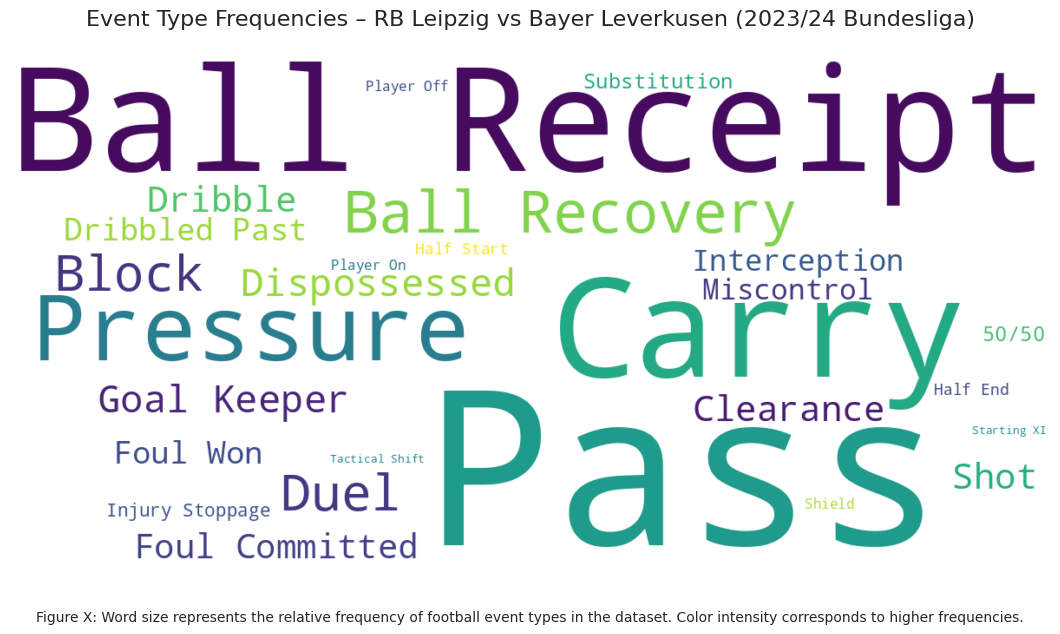

From the complete set of event data columns, only a subset is useful for shot analysis in the context of expected goals modelling, as numerous fields are not applicable to this event type and therefore empty. Table 1 summarises the retained columns, grouped by functional category.

| **Category**               | **Variables** | **Description** |
|----------------------------|---------------|-----------------|
| **Identifiers**            | `id`, `index`, `match_id` | Unique identifiers for the event, its order in the match, and the match itself. |
| **Temporal information**   | `period`, `timestamp` | Match period and exact time of the shot. |
| **Team & player**          | `team_id`, `team_name`, `player_id`, `player_name`, `position_id`, `position_name` | Identifies the shooting team, player, and their position at the time of the shot. |
| **Location data**          | `x`, `y`, `end_x`, `end_y`, `end_z` | Pitch coordinates of the shot and the end location of the ball’s trajectory (StatsBomb units). |
| **Shot execution details** | `body_part_id`, `body_part_name`, `technique_id`, `technique_name`, `sub_type_id`, `sub_type_name`, `shot_statsbomb_xg`, `shot_key_pass_id` | Categorisation of shot method, body part used, specific type, expected goals value, and link to preceding key pass. |
| **Contextual indicators**  | `under_pressure`, `off_camera`, `out`, `aerial_won`, `shot_first_time`, `shot_one_on_one`, `shot_deflected`, `shot_open_goal`, `shot_redirect`, `shot_follows_dribble` | Boolean indicators capturing situational or execution-specific context. |
| **Outcome**                | `outcome_id`, `outcome_name` | Result of the shot (e.g., goal, saved, blocked). |
| **Additional context**     | `minute`, `second`, `duration`, `half_start_late_video_start`, `half_end_early_video_end`, `pass_backheel`, `possession`, `possession_team_id`, `possession_team_name`, `play_pattern_id`, `play_pattern_name` | Supplementary temporal and tactical context. |

To construct a unified dataset for model training, all shot events were collected from every match in every competition available in the StatsBomb repository. The custom data-loading script is based on the open-source [statsbombpy](https://github.com/statsbomb/statsbombpy) Python library, which provides functions to retrieve competitions, matches, lineups, and event data directly into `pandas` DataFrames.

The individual match-level shot dataframes were appended into a single shots_master_df **(Link einfügen)**. After concatenation, only the identified relevant columns were kept, resulting in a dataset containing only variables applicable to shots across all competitions. This ensured that subsequent modelling steps are based on a clean, relevant feature set.

Freeze-frame data provide a snapshot of all players’ positions and the ball location at the exact moment a shot is taken. Each shot event in the StatsBomb dataset includes a corresponding freeze-frame entry in the df_freeze dataframe, linked via the event’s unique id. This structure enables the retrieval of all relevant player objects for a specific shot, including attributes such as pitch coordinates (x, y), team affiliation (teammate), and positional role (position_name). For example, filtering df_freeze by a given shot id yields the spatial context for that event.

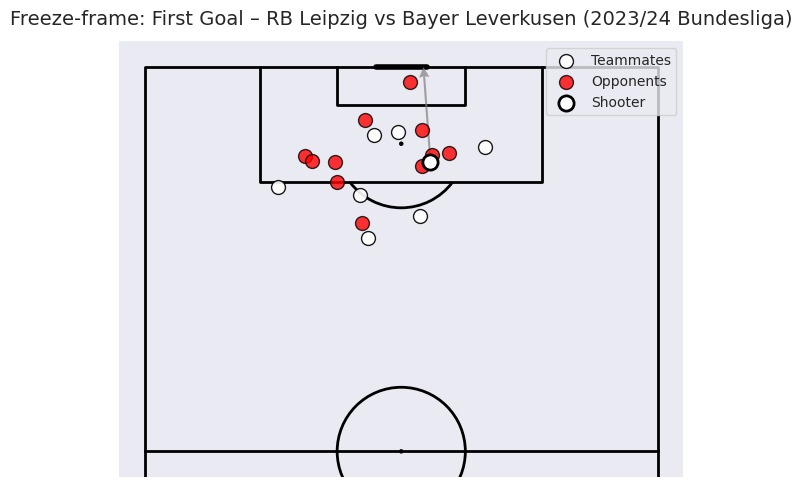


# 3. Data Preprocessing


Following the identification of event-level variables relevant for shot analysis, the subsequent step involves deriving a set of explanatory features for modelling. This transformation process converts raw event and freeze-frame data into numerical and binary indicators that represent spatial relationships, tactical context and technical execution. The resulting feature set is designed to capture the primary factors hypothesised to influence shot outcomes, while maintaining a consistent representation across matches and competitions.


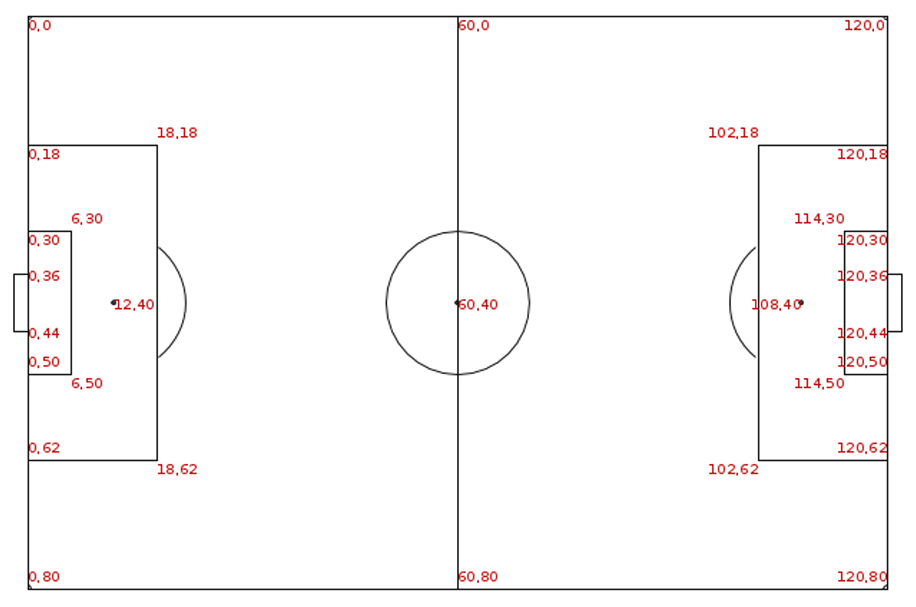

All positional quantities are expressed in pitch units (pu) according to the StatsBomb coordinate system ($120 \times 80$ pu for pitch length × width), thereby ensuring comparability without stadium-specific scaling. Additionally, in the StatsBomb coordinate system, all shots are standardised to a single attacking direction, ensuring consistent geometric feature calculation. The feature set is detailed below.

**1. Numerical features**

Let $i$ index shots.
Shots are standardised to a single attacking direction,

- **Distance to goal** (`distance_to_goal`)  
  Euclidean distance from the shot location $\mathbf{s}_i=(x_i,y_i)$ to the goal centre $\mathbf{g}=(120,40)$:  
  $$
  d_i = \sqrt{(x_i - 120)^2 + (y_i - 40)^2} \quad [\text{pu}].
  $$  
  This metric captures the proximity of the shooter to the goal; lower values correspond to closer shooting positions and are typically associated with higher scoring probability.

- **Angle to goal** (`angle_to_goal_deg`)  
  Opening angle $\theta_i$ subtended by the goalposts $\mathbf{p}_\mathrm{L}=(120,36)$ and $\mathbf{p}_\mathrm{R}=(120,44)$ at $\mathbf{s}_i$:  
  Let  
  $$
  a = \lVert \mathbf{s}_i - \mathbf{p}_\mathrm{L} \rVert_2, \quad
  b = \lVert \mathbf{s}_i - \mathbf{p}_\mathrm{R} \rVert_2, \quad
  c = 8\ \text{pu}
  $$  
  where $c$ is the official goal width in StatsBomb units. Then  
  $$
  \theta_i = \arccos\!\left( \frac{a^2 + b^2 - c^2}{2ab} \right), \quad
  \theta_i^{(\circ)} = \frac{180}{\pi}\theta_i.
  $$  
  Larger angles indicate more central shooting positions with greater visible goal area.


- **Opponents in way** (`opponents_in_way`)  
  Count of opposition players located within the *shooting triangle* defined by the shooter’s location and the two goalposts. Player positions are obtained from the freeze-frame data for the corresponding shot and tested for inclusion within the triangle using a barycentric sign method **(Quelle einfügen)**.

- **Teammates in way** (`teammates_in_way`)  
  Count of players on the shooter’s own team whose positions fall within the same shooting triangle. Although not defensive obstacles, such players may partially obscure the goalkeeper’s view or affect defensive positioning.

- **With dominant foot** (`with_dominant_foot`)  
  Binary indicator taking the value `1` if the recorded shot body part corresponds to the shooter’s dominant foot, and `0` otherwise. **(Erklären woher die Info kommt, wo die flaws liegen etc.)**

**2. Binary features**  

This group comprises indicator variables ($0 =$ false, $1 =$ true) capturing the situational context of the shot, its execution technique, the phase of play, and the body part used. All variables are derived from categorical fields in the StatsBomb event data and represented using one-hot encoding where applicable.

**Shot context**  
- `shot_first_time` — Shot taken without controlling the ball prior to execution.  
- `shot_one_on_one` — Shooter in direct confrontation with the goalkeeper, without an intervening defender.  
- `shot_open_goal` — Goalkeeper absent from a position to make a save.  

**Technique**  
- `technique_Backheel`  
- `technique_Diving Header`  
- `technique_Half Volley`  
- `technique_Lob`  
- `technique_Normal`  
- `technique_Overhead Kick`  
- `technique_Volley`  
Each variable flags the presence of the corresponding shooting technique.  

**Phase of play**  
- `subtype_Free Kick` — Direct shot taken from a free kick.  
- `subtype_Open Play` — Shot occurring during continuous play.  
- `subtype_Penalty` — Penalty kick taken from the spot.  

**Body part**  
- `is_header` — Shot executed with the head.  

The final dataset including all features is stored here **(Einfügen)**

## 4. Probabilistic Modeling Approach



As stated in the introduction, the objective of this project is to estimate the probability that a given shot results in a goal as a function of spatial, contextual, and categorical features. One central aim of the work is to evaluate whether explicitly modelling predictive uncertainty can enhance the accuracy and interpretability of expected goals estimates and whether such uncertainty measures provide additional insights into differences between players, shot types, or match contexts. To address these objectives, three complementary model classes are employed. Logistic Regression (LR) serves as a transparent and interpretable baseline, offering a well-established benchmark in football analytics for relating shot features to scoring probability. **(Quelle einfügen)** Bayesian Logistic Regression (BLR) extends this foundation by introducing parameter uncertainty, allowing the model to express confidence in its estimates. Bayesian Neural Networks (BNN) further enhance modelling capacity by capturing complex nonlinear relationships between features, such as interactions between shooting angle, shot technique and body part used, while still producing predictive distributions. Together, these models provide a spectrum from interpretability and simplicity to flexibility and expressive power, enabling an evaluation of probabilistic approaches in the expected goals context.

###Logistic Regression  
Logistic regression serves as a transparent, interpretable baseline model. Given a feature vector $\mathbf{x}_i$ for shot $i$, the goal probability is modelled as:

$$
p(y_i = 1 \mid \mathbf{x}_i) = \sigma(\mathbf{w}^\top \mathbf{x}_i) = \frac{1}{1 + e^{-\mathbf{w}^\top \mathbf{x}_i}}
$$

where $y_i \in \{0,1\}$ indicates goal outcome and $\mathbf{w}$ is the vector of learned coefficients.  
Logistic Regression is widely used in football analytics due to its computational efficiency and the direct interpretability of its parameters, which indicate how each feature affects the log-odds of scoring.

###Bayesian Logistic Regression
BLR extends the frequentist LR by introducing a prior distribution over model parameters, for example:

$$
\mathbf{w} \sim \mathcal{N}(\mathbf{0}, \tau^2 \mathbf{I})
$$

Posterior inference is then performed via Bayes’ theorem:

$$
p(\mathbf{w} \mid D) \propto p(D \mid \mathbf{w}) \, p(\mathbf{w})
$$

where $D$ denotes the training data. Predictions marginalise over the posterior:

$$
p(y_i = 1 \mid \mathbf{x}_i, D) = \int \sigma(\mathbf{w}^\top \mathbf{x}_i) \, p(\mathbf{w} \mid D) \, d\mathbf{w}
$$

This approach captures parameter uncertainty, translating it into predictive uncertainty and allows the model to express its confidence (or lack thereof) in the estimated goal probabilities.

###Bayesian Neural Networks
BNNs generalise the Bayesian approach to flexible, nonlinear models. The linear mapping of LR is replaced by a multi-layer feedforward neural network:

$$
\mathbf{h}^{(1)} = \phi(\mathbf{W}^{(1)} \mathbf{x} + \mathbf{b}^{(1)}), \quad
\hat{y} = \sigma(\mathbf{W}^{(L)} \mathbf{h}^{(L-1)} + \mathbf{b}^{(L)})
$$

where each weight matrix $\mathbf{W}^{(l)}$ and bias vector $\mathbf{b}^{(l)}$ has a prior distribution, and approximate inference (e.g., variational Bayes, Monte Carlo dropout) is used to estimate the posterior.  
BNNs can model complex interactions between features while still producing full predictive distributions.


These probabilistic models are particularly appropriate for expected goals estimation because they provide both a point prediction and a measure of uncertainty. Two shots with the same mean xG can differ greatly in variance depending on factors such as defensive pressure or shooting technique. By modelling uncertainty explicitly, it becomes possible to distinguish between consistent chance creation and volatile, high-risk opportunities, supporting more informed decision-making in scouting, tactics, and player development.


# 5. Model Training and Evaluation


The following section describes how these models were implemented, trained, and evaluated on the dataset. Model training used the processed shot dataset from Section&nbsp;3, with binary target $y$ ($1$ = goal, $0$ = no goal).  
The data are class-imbalanced, with goals forming only a small fraction of shots. This was addressed through stratified data splits and model-specific strategies.

### Logistic Regression  
Implemented via scikit-learn’s `LogisticRegression` (`lbfgs` solver, max_iter=1000) with `class_weight='balanced'` to weight classes inversely to their frequency.  
Data were split into 80% train / 20% test using `train_test_split` with stratification. Preprocessing was handled by a scikit-learn `Pipeline` to ensure consistent transformation within each cross-validation fold.

Predicted probabilities were calibrated using `CalibratedClassifierCV` with sigmoid (Platt scaling) and 5-fold internal CV, mapping raw outputs to values that better reflect observed goal rates.  
Performance was evaluated with stratified 5-fold CV on the training set.

### Bayesian Logistic Regression  
Implemented in PyMC to extend LR by modelling parameter uncertainty.  
Gaussian priors $\mathcal{N}(0, 5^2)$ were placed on intercept and coefficients. Posterior inference used the NUTS sampler (1000 draws, 1000 tuning, target_accept=0.9).  

Posterior samples yielded predictive means (averaging sigmoid-transformed linear predictors across draws) and full predictive distributions, enabling shot-level uncertainty quantification.

### Bayesian Neural Network (BNN)  
A PyMC single hidden-layer network with 5 $\tanh$ units. Gaussian priors $\mathcal{N}(0, 0.5^2)$ were placed on all weights/biases.  
Given scaled inputs $\mathbf{X}$:

$$
\mathbf{h} = \tanh(\mathbf{X} \mathbf{W}_\mathrm{hidden} + \mathbf{b}_\mathrm{hidden})
$$

$$
\ell = \mathbf{h}^\top \mathbf{w}_\mathrm{out} + b_\mathrm{out}, \quad p = \sigma(\ell)
$$

A Bernoulli likelihood linked $p$ to outcomes. NUTS sampling (400 warmup + 400 draws, 2 chains) balanced nonlinear capacity with tractability.

### Calibration  
Calibration checks whether predicted probabilities match observed frequencies. A calibration curve plots mean predicted probability (x-axis) vs. actual goal frequency (y-axis); a perfectly calibrated model lies on:

$$
y = x
$$

Calibration here is a post-processing step:

$$
p_{\text{calibrated}} = f\big(p_{\text{original}}\big)
$$

where $f(\cdot)$ maps uncalibrated to calibrated probabilities.  
In xG modelling, this ensures, e.g., that $0.25$ predicted truly corresponds to a 25% historical scoring rate which is critical when aggregating xG or comparing players.

### Evaluation Metrics  
Models are assessed using discrimination, probabilistic scoring and calibration measures:  

- **AUC (ROC)** – Ability to rank goals above non-goals (0.5 = random, 1.0 = perfect).  
- **Accuracy** – Correct classifications at threshold 0.5; reported for completeness.  
- **Log-Loss** – Penalises miscalibration and overconfidence:  
  $$
  \text{LogLoss} = -\frac{1}{N} \sum_{i=1}^N \left[ y_i \log \hat{p}_i + (1 - y_i) \log (1 - \hat{p}_i) \right]
  $$  
- **Brier Score** – Mean squared error between $\hat{p}_i$ and $y_i$:  
  $$
  \text{Brier} = \frac{1}{N} \sum_{i=1}^N (\hat{p}_i - y_i)^2
  $$  

Additionally, visual diagnostics included ROC curves (TPR vs. FPR) and Precision–Recall curves (highlighting rare-event detection).

### Uncertainty Quantification  
For Bayesian models, predictive uncertainty was estimated as the standard deviation of predicted probabilities across posterior draws:  

- **BLR** – Derived from posterior coefficient samples.  
- **BNN** – From multiple stochastic forward passes (dropout at test time).  

This enables comparison not just of expected goal probabilities, but also of the model’s confidence in those estimates, highlighting stable versus volatile shooting situations.


# 6. Results





| Model                     | Calibration | AUC   | Accuracy | Log-Loss | Brier  | AP    |
|---------------------------|-------------|-------|----------|----------|--------|-------|
| Logistic Regression | Before      | 0.807 | 0.761    | 0.523    | 0.170  | 0.439 |
| Logistic Regression | After       | 0.807 | 0.901    | 0.278    | 0.080  | 0.439 |
| Bayesian Logistic Reg.    | Before      | 0.805 | 0.902    | 0.277    | 0.079  | 0.442 |
| Bayesian Logistic Reg.    | After       | 0.805 | 0.902    | 0.285    | 0.081  | 0.442 |
| Bayesian Neural Network   | Before      | 0.813 | 0.904    | 0.271    | 0.077  | 0.467 |
| Bayesian Neural Network   | After       | 0.813 | 0.904    | 0.277    | 0.078  | 0.467 |

Table 1 summarises the performance of all models before and after probability calibration.  

Across all models, AUC values indicate strong discrimination between goals and non-goals, with the BNN achieving the highest score (0.813) and both LR and BLR performing comparably.  
Although post-calibration accuracy values are uniformly high (> 0.90), this metric has limited interpretive value in this imbalanced setting, as high accuracy can be achieved without genuine discrimination simply by predicting the majority class.
Log-Loss and Brier scores demonstrate that probability calibration substantially improved the LR model, while the Bayesian models were already well calibrated and showed only marginal changes.

These patterns are consistent with the ROC and Precision–Recall curves (Figure X), which show substantial overlap in ranking performance but reveal a modest advantage for the BNN in rare-event detection.

The BNN achieved slightly higher discrimination and probabilistic scores, likely due to its ability to model nonlinear feature interactions. LR remains the most interpretable baseline with competitive performance, while BLR offers a middle ground by matching LR’s accuracy and additionally quantifying uncertainty for risk-aware decision-making.

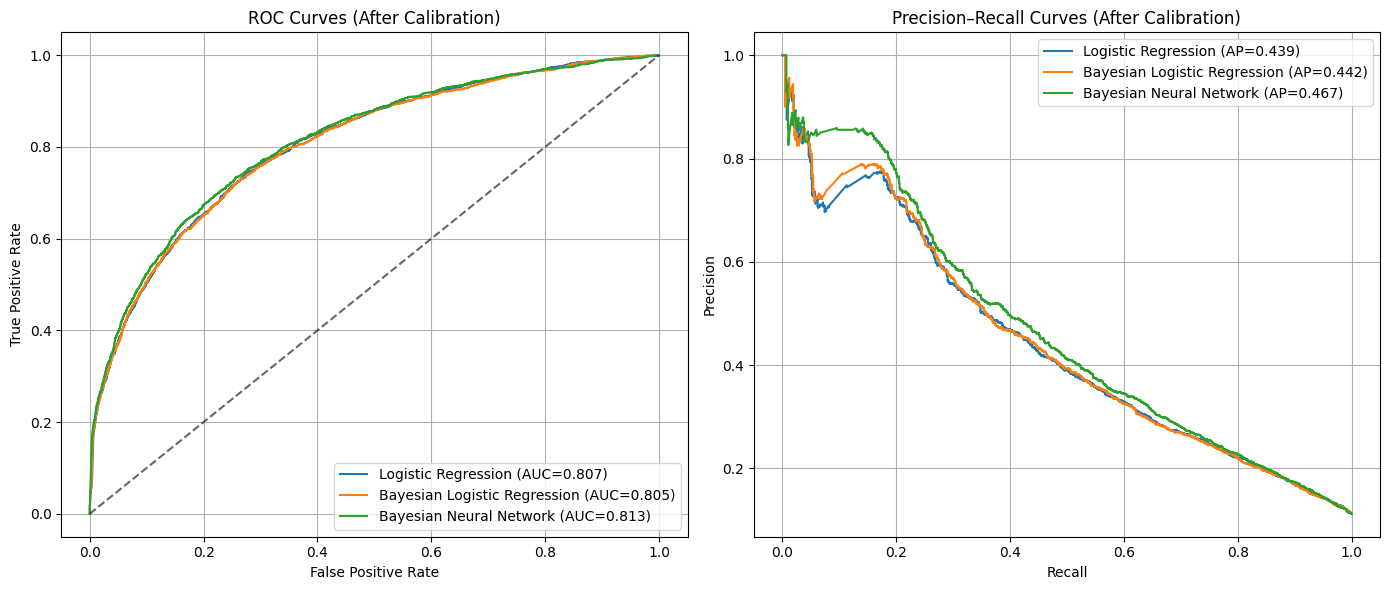

Predictive uncertainty was quantified as the standard deviation of posterior predictive probabilities for each shot.  
Table X summarises the distribution of these uncertainties for the Bayesian models.

| Model | Mean Std. Dev. | Median Std. Dev. | 25th Pctl | 75th Pctl | Max |
|-------|---------------|------------------|-----------|-----------|-----|
| BLR   | 0.004         | 0.003            | 0.002     | 0.005     | 0.049 |
| BNN   | 0.008         | 0.006            | 0.003     | 0.011     | 0.115 |

The **BNN** exhibited a wider spread of uncertainty values (max = 0.115) than the **BLR** (max = 0.049), suggesting that the BNN not only captures more complex feature interactions but also expresses greater variation in confidence across shot contexts.  

The most certain predictions for both models corresponded to extremely low-probability shots (predicted $p \approx 0.0$, all actual misses).  
The most uncertain predictions tended to have predicted probabilities near the decision boundary ($p \approx 0.5{-}0.7$) where the model has limited precedent in the training data.  

For example:  
- **BLR highest uncertainty**: predicted $p \approx 0.53$, actual goal (std = 0.047)  
- **BNN highest uncertainty**: predicted $p \approx 0.50{-}0.84$, all actual goals (std = 0.09–0.11)  

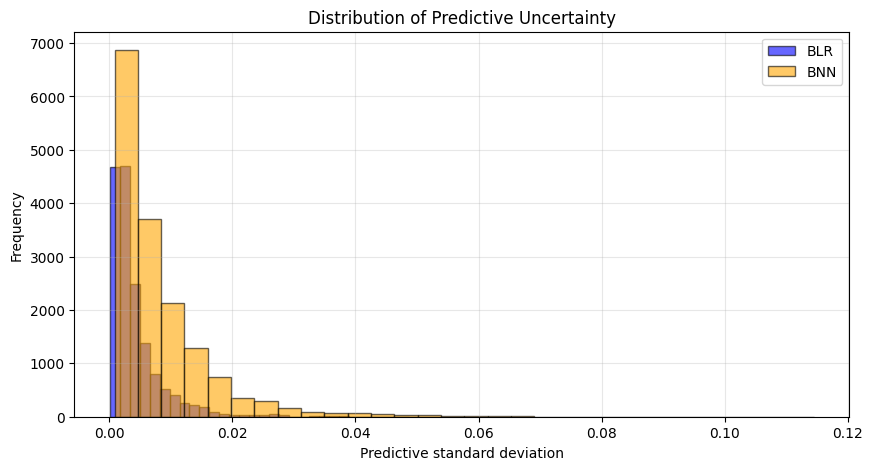

Figure X shows histograms of predictive standard deviations for both models, highlighting that the BNN’s distribution is wider, reflecting its greater capacity to represent uncertainty in ambiguous cases.

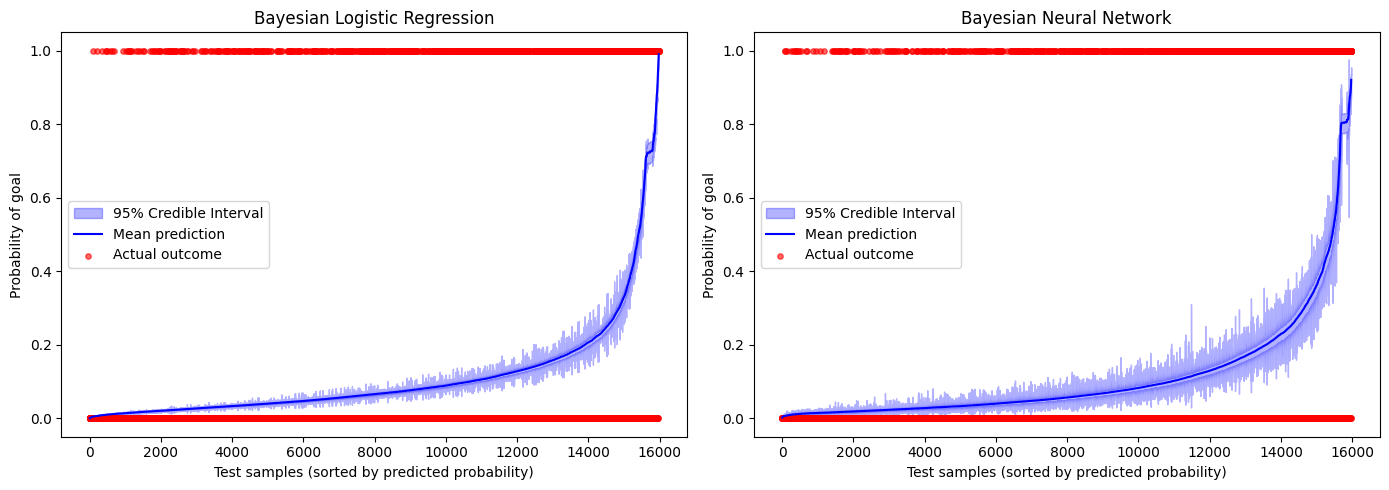

Figure Y illustrates the 95% credible intervals for all test samples, sorted by predicted mean probability. Uncertainty is minimal at the extremes (near-certain predictions) and largest for mid-range probabilities, reflecting the inherent ambiguity of borderline cases. The BNN shows consistently wider intervals than the BLR, in line with its broader uncertainty distribution observed in Figure X.

# 7. Discussion


Across all models, AUC values indicate strong discrimination between goals and non-goals, with the Bayesian Neural Network (BNN) achieving the highest score (0.813) and slightly outperforming Logistic Regression (LR) and Bayesian Logistic Regression (BLR) in average precision. Probability calibration markedly improved LR’s Log-Loss and Brier score, while the Bayesian models were already well calibrated, showing minimal change after post-processing.

The BNN’s modest advantage in ROC and precision–recall curves likely reflects its ability to model nonlinear feature interactions.

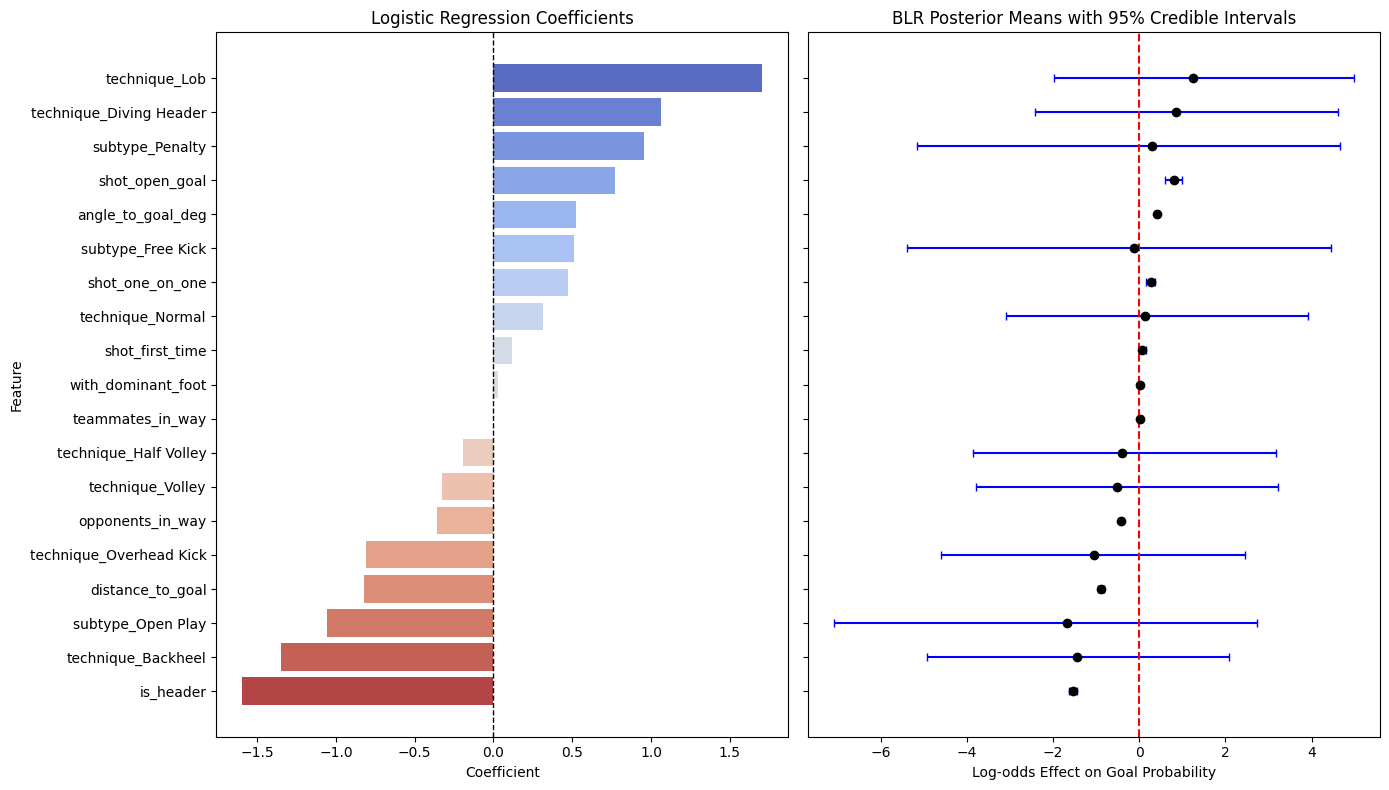

The side-by-side comparison of LR and BLR coefficients reveals broad agreement in the direction of effects. Features such as `technique_Lob`, `shot_open_goal`, and `angle_to_goal_deg` are strongly associated with increased scoring probability, while `is_header`, `distance_to_goal`, and `opponents_in_way` reduce it.  
However, BLR posterior means are generally smaller in magnitude than LR coefficients, reflecting the regularising influence of the Bayesian prior.  
Crucially, the BLR intervals quantify uncertainty, showing where strong LR coefficients may be based on sparse evidence, for example in features with few training samples.
For instance, while both models identify `technique_Lob` as highly positive, BLR’s wide credible interval suggests caution in interpretation.
In contrast, `shot_open_goal` exhibits a narrow interval well above zero, indicating high confidence in its positive impact.  
This comparison highlights that Bayesian modelling not only preserves key effect patterns from LR but also provides valuable measures of confidence, helping to separate robust findings from potentially spurious associations.  
The BNN with its non-linear architecture does not yield a single, globally interpretable set of coefficients, as feature effects are context-dependent and distributed across the network’s weights. Future work could apply model-agnostic interpretability techniques, such as SHAP values or permutation importance, to make BNN results more comparable to LR and BLR.

Regarding limitations, it must be mentioned that the feature set, while covering key spatial and contextual variables, omits potentially important factors such as defensive positioning, player fatigue or ball trajectory. Computational constraints also restricted the BNN architecture and sampling depth, which may limit its ability to fully capture complex interactions. In addition, while LR performance was estimated using stratified 5-fold cross-validation, BLR and BNN were evaluated on a single hold-out split due to the cost of repeated MCMC sampling, making their results more sensitive to the chosen split. Therefore, future work could explore richer feature sets, more expressive Bayesian deep learning architectures, and apply cross-validation to Bayesian models using fewer folds or faster approximate inference, alongside alternative calibration methods and uncertainty quantification techniques (e.g. ensemble Bayesian models), to further improve reliability and interpretability.

Looking ahead, a natural next step would be to evaluate the models on genuinely unseen data from future competitions, such as the recently released UEFA Women’s Euro 2025 data to assess their robustness. This out-of-sample testing would provide a stringent check on both discrimination and calibration under new conditions. Such evaluation would also offer opportunities to adapt the models through transfer learning or Bayesian updating, ensuring that predictions remain accurate and well-calibrated as the game evolves.

# 8. Conclusion



Logistic Regression remains the most interpretable baseline, offering competitive performance with minimal complexity, making it a strong choice when transparency is needed. Bayesian Logistic Regression preserves this interpretability while adding quantified predictive uncertainty, enabling a clearer separation between robust and less certain findings. The Bayesian Neural Network, although less interpretable in a traditional coefficient-based sense, demonstrated the strongest overall discrimination and probabilistic scoring. Its ability to model nonlinear feature interactions, combined with quantified uncertainty, makes it the preferred choice when the aim is maximum predictive performance and richer decision support.  

Across the study, explicitly modelling predictive uncertainty did not compromise accuracy. In fact, the BNN slightly outperformed the baselines in both discrimination and average precision. More importantly, uncertainty quantification revealed patterns that point estimates alone would have missed such as borderline shots, rare techniques, and scenarios with limited historical precedent, all of which showed elevated uncertainty. These insights are particularly valuable for scouting, tactical design and player development where understanding both the probability of success and the confidence in that probability supports more informed decision-making.  

However, predictive performance alone is not enough. In the football context, explainability is essential. A model’s value lies not only in its predictions but also in its ability to show players and coaches which factors most influence scoring chances and how reliably it can make those claims. While LR excels in clarity and communication, the BLR offers a strong compromise, retaining interpretability while providing quantified uncertainty, although this comes at a significantly higher computational cost compared to LR. The BNN delivers the most complete package in terms of predictive performance and uncertainty awareness, but at the expense of direct interpretability, which may limit its acceptance among non-scientific stakeholders in the footballing world.


# 9. References

- Cite any papers, datasets, or tools used

- StatsBomb (2025). *StatsBomb Open Data*. GitHub repository: [https://github.com/statsbomb/open-data](https://github.com/statsbomb/open-data)  
  Dataset containing detailed football event data, including freeze-frame information for shots.

- Neal, R. M. (2012). *Bayesian Learning for Neural Networks*. Springer Science & Business Media.  
  Foundational work on Bayesian neural networks.

- Bishop, C. M. (2006). *Pattern Recognition and Machine Learning*. Springer.  
  Comprehensive reference for probabilistic modelling and machine learning theory.

- Brier, G. W. (1950). *Verification of Forecasts Expressed in Terms of Probability*. Monthly Weather Review, 78(1), 1–3.  
  Original description of the Brier score metric.

- Murphy, K. P. (2012). *Machine Learning: A Probabilistic Perspective*. MIT Press.  
  Detailed coverage of Bayesian logistic regression and probabilistic inference methods.

- Pedregosa, F., Varoquaux, G., Gramfort, A., et al. (2011). *Scikit-learn: Machine Learning in Python*. Journal of Machine Learning Research, 12, 2825–2830.  
  Library used for logistic regression and evaluation metrics.

- StatsBombPy (2025). *Python client for StatsBomb data*. GitHub repository: [https://github.com/statsbomb/statsbombpy](https://github.com/statsbomb/statsbombpy)  
  Tool for loading and processing StatsBomb Open Data in Python.

- Kingma, D. P., & Welling, M. (2014). *Auto-Encoding Variational Bayes*. arXiv preprint arXiv:1312.6114.  
  Methodology underlying variational inference for Bayesian models.

- Gal, Y., & Ghahramani, Z. (2016). *Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning*. In *Proceedings of the 33rd International Conference on Machine Learning (ICML)*.  
  Approach used for Monte Carlo dropout in Bayesian neural networks.
